In [60]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

Note: make sure that this data set is in the directory returned by the `path` variable below

In [61]:
path = Config().data_path()/'mnist'
path

PosixPath('/Users/paigefink/.fastai/data/mnist')

In [62]:
path.ls()

[PosixPath('/Users/paigefink/.fastai/data/mnist/mnist.pkl.gz')]

In [63]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [64]:
len(x_train)

50000

In [65]:
x_train.shape

(50000, 784)

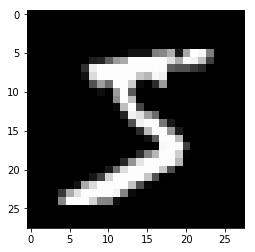

In [66]:
plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")

In [67]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n, c = x_train.shape
print(n)
print(c)
x_train.shape, y_train.min(), y_train.max()

50000
784


(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [68]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [76]:
train_ds[0][1].item()

5

In [77]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [78]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [79]:
model = Mnist_Logistic()

In [80]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [81]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [82]:
model(x).shape

torch.Size([64, 10])

In [83]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [89]:
lr=2e-2

In [90]:
loss_func = nn.CrossEntropyLoss()

In [91]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [92]:
losses = [update(x,y,lr) for x,y in data.train_dl]

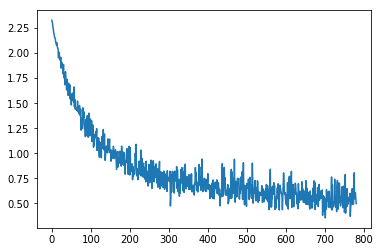

In [93]:
plt.plot(losses);

In [94]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [95]:
model = Mnist_NN()

In [96]:
losses = [update(x,y,lr) for x,y in data.train_dl]

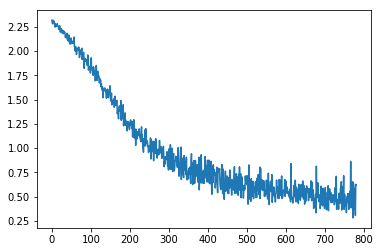

In [97]:
plt.plot(losses);

In [110]:
model = Mnist_NN()

In [111]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [112]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

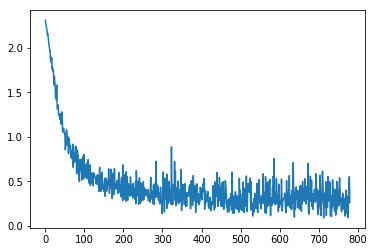

In [113]:
plt.plot(losses);

In [114]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

In [32]:
%debug

> /anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py(92)_check_driver()
     90 def _check_driver():
     91     if not hasattr(torch._C, '_cuda_isDriverSufficient'):
---> 92         raise AssertionError("Torch not compiled with CUDA enabled")
     93     if not torch._C._cuda_isDriverSufficient():
     94         if torch._C._cuda_getDriverVersion() == 0:

ipdb> 
ipdb> quit


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


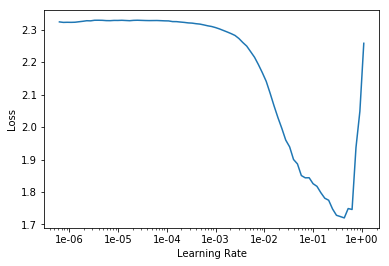

In [115]:
learn.lr_find()
learn.recorder.plot()

In [117]:
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.164276,0.156341,0.956500,00:04
1,0.082285,0.099886,0.970600,00:03


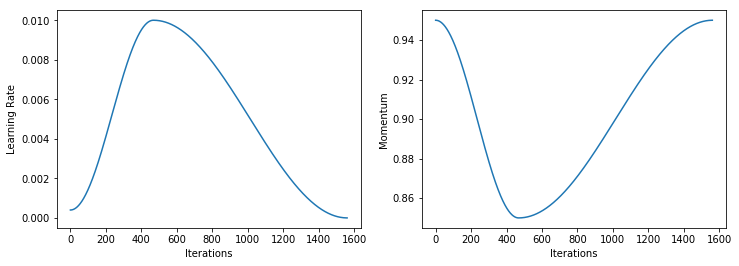

In [118]:
learn.recorder.plot_lr(show_moms=True)

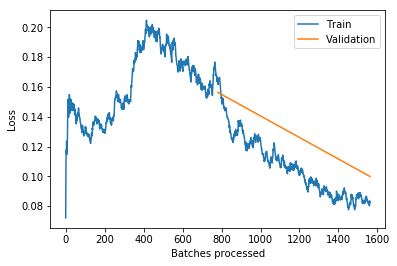

In [120]:
learn.recorder.plot_losses()